# Grover search algorithm

<center><img src="../../figures/qibo_mascotte/qibo_coffee.png" alt="drawing" width="400"/></center>
<center>Who put sugar in Qibo's coffee? [DALL-E].</center>

## Introduction

The Grover algorithm is probably one of the most famous quantum computing proof of utility. 

It has been known as "Grover search algorithm" because it is effective in a context in which we aim to find a specific solution of a problem among a set of possible solutions. 

#### Problem setup

In this notebook, we are going to implement the Grover algorithm using a system of $N$ qubits in order to explore a set of $M=2^N$ possible solutions and, without going deep into the mathematical details, we will proof we need a number of Grover iterations proportional to $\sqrt{M}$ to find the target solution with probability close to one.

---

To give the lesson a more concrete aspect, let's take a more realistic problem: 
Suppose you're at a party with $M=2^N$ friends. While you're peacefully drinking your coffee, you get distracted for a moment, and someone, without you noticing, pours sugar into your coffee.

It's a disaster because you like your coffee bitter! So, you absolutely need to find the person responsible for this.

Let's also suppose that there is no concrete evidence that can lead us to the guilty person, however, while poursing coffee inside your mug, the thief left a hair inside the cup, which can be used to extract DNA.

Perfect! we can compare the guilty DNA with that of every person who was at the party at that moment.

---

This problem can be **classically** tackled by checking all the people one by one and, in the worst case, it takes $M = 2^N$ attempts before finding the guilty person in the group. On the other hand, using quantum computing and the Grover algorithm, we will see the solution can be found with a number of algorithm's calls that scales as $\sqrt{M}$: *we gain a quadratic speedup!*

Let's start investigating the culprit by importing some packages.

In [1]:
# if you don't have already qibo, qibojit and qiboedu installed in your computer
# uncomment and execute the following lines 

# !pip install qibo
# !pip install qibojit
# !pip install git+https://github.com/qiboteam/qiboedu

In [2]:
# import random, numpy, matplotlib
import random 

import numpy as np
import matplotlib.pyplot as plt

# import qibo and its modules
import qibo
from qibo import Circuit, gates

# import all utils and plotscripts modules from scripts
from qiboedu.scripts import utils, plotscripts

# set qibo backend
qibo.set_backend("numpy")

[Qibo 0.2.15|INFO|2025-01-16 15:50:50]: Using numpy backend on /CPU:0


Secondly, we need to generate a set of elements which can deal with a quantum computer and are able to represent all the possible solutions we want to explore. In practice, we create a set of $2^N$ bitstrings and we associate every person at the party to one of the bistrings. 

We use the function `scripts.utils.generate_bitstring_combination` to generate a list containing all the possible bitstrings of zeros and ones composed of $N$ bits.

In [3]:
# set the problem dimensionality --> the size of the set to be explored
n = 5

# set the number of shots (circuit's executions)
# we do this because it's more realistic 
nshots = 1000000

# generate bitstrings list
bitstrings = utils.generate_bitstring_combinations(n)

print(bitstrings)

['00000', '00001', '00010', '00011', '00100', '00101', '00110', '00111', '01000', '01001', '01010', '01011', '01100', '01101', '01110', '01111', '10000', '10001', '10010', '10011', '10100', '10101', '10110', '10111', '11000', '11001', '11010', '11011', '11100', '11101', '11110', '11111']


In [4]:
# check whether the length of the list is equal to 2**n
print(len(bitstrings) == 2**5)

True


Let's generate the list of people who were at the party.

In [5]:
# !pip install Faker 
from faker import Faker
fake = Faker()

In [6]:
names = []
for i in range(2**n):
    names.append(fake.name())

print(names)

['Joy Graves', 'Walter King', 'Angela Bowman', 'Robert Meza', 'Michael Rodriguez', 'Dillon Smith', 'Ann Patton', 'Dakota Scott', 'Heidi Blake', 'Dana Morgan', 'Jill Martinez', 'Megan Walker', 'Colleen Jacobs', 'Tyler Washington', 'Samuel Parks', 'Christian Garcia', 'Lynn Olson', 'Cory Valentine', 'Douglas Ayers', 'Jennifer Ramirez', 'Jennifer Simmons MD', 'Yolanda Collins', 'Sandra Haynes', 'John Gonzales', 'Katrina Vargas', 'Seth Cox', 'Andrew Johnson', 'Emily Burton', 'William Bryant', 'Eric Jones', 'Derek Frank', 'Julie Diaz']


In practice, we have now a list of strings, in which the element of index $k$ represents the $k$-th suspect among the people.

Let's assume the guilty guy in the list is the number 11!

In [7]:
guilty_index = 11
print(f"Guilty index: {guilty_index}")
print(f"Guilty {names[guilty_index]} corresponding to state {bitstrings[guilty_index]}")

Guilty index: 11
Guilty Megan Walker corresponding to state 01011


### Grover algorithm main ingredients

Now the problem is set up and we can focus on the Grover implementation. 

<center><img src="../../figures/grover-circ.png" alt="drawing" width="800"/></center>
We need to follow some steps:

1. we prepare a system of $N+1$ qubits into the $|0\rangle^{\otimes N} |1\rangle$ state. The ancilla gate is the one prepared as usual into $|1\rangle$;
2. we apply Hadamard gates to all the qubits in order to create superposition of all the $2^N$ states of the input register. We call this superposed state $|s\rangle$;
3. we apply an **oracle** function $U_f$ to the qubits, which is constructed in order to detect the guilty state among the others. In our narrative, it can be seen as the machine which process the DNA of the people, allowing to find the guilty person. In a quantum computer notation, it is a set of operation which flips the sign of the amplitude of the state corresponding to the guilty guy (the number 11 in our case).
4. we apply the **diffusion operator** $U_s = 2|s\rangle \langle s| - I$, whose effect consists in reflecting the amplitudes of the system about the average amplitude. In practice, acting together with the oracle over the superposed states, it increases the amplitude of the guilty state and decrease the one of the others.
5. we repeat the process a number of time proportional to $\sqrt{M}$ to find the guilty guy state with probability close to one.

We see some more detail in the following cells. For now, we can start implementing all the elements of the Grover algorithm.

#### Initial and final layers of the circuit

Regardless of the number of times we repeat the application of $U_f$ and $U_s$, we need to build the initial and the final circuit layer.

In [8]:
# The Grover circuit will be composed of many layers
# the first and the last layer are always the same and we call the initial_layer and final_layer

# set the circuit and initial superposition
def build_initial_layer(n):
    """Build the initial superposition in Grover circuit."""
    # n+1 qubits circuit
    c = Circuit(n+1)
    # state preparation into |0>|0>...|1>
    c.add(gates.X(n))
    # add superposition
    for q in range(n+1):
        c.add(gates.H(q))
        
    return c

# final measurements
def build_final_layer(n):
    # n+1 qubits circuit
    c = Circuit(n+1)
    # measurements
    c.add(gates.M(*range(n)))
    return c

Let's visualize the initial and final layer.

In [9]:
# build the circuit as initial_layer + final_layer and draw it
c = build_initial_layer(n) + build_final_layer(n)

c.draw()

0: ─H───M─
1: ─H───M─
2: ─H───M─
3: ─H───M─
4: ─H───M─
5: ─X─H───


With this setup, the final state is the equally superposed state and we expect uniformly distributed probabilities between all the available states.
To visualize it, we can use the `scripts.plotscripts.plot_grover_probabilities` function, which shows the probability of each state calculated using the collected frequencies after executing the circuit `nshots` times.

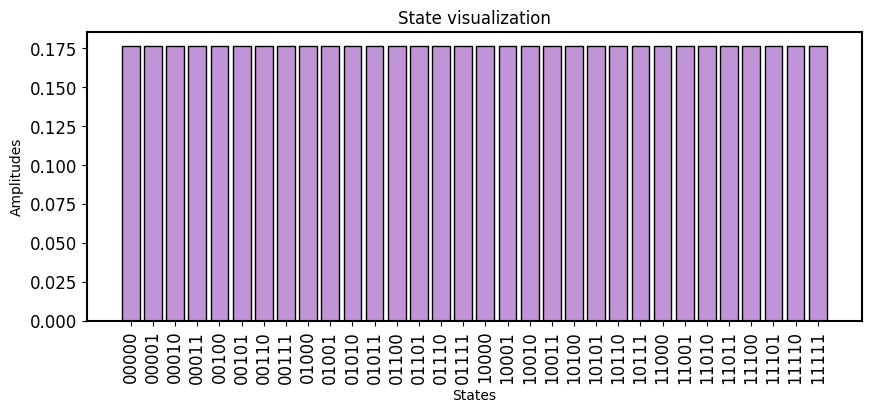

In [10]:
# use plot_input_register_amplitudes passing the quantum state
plotscripts.plot_input_register_amplitudes(c().state())

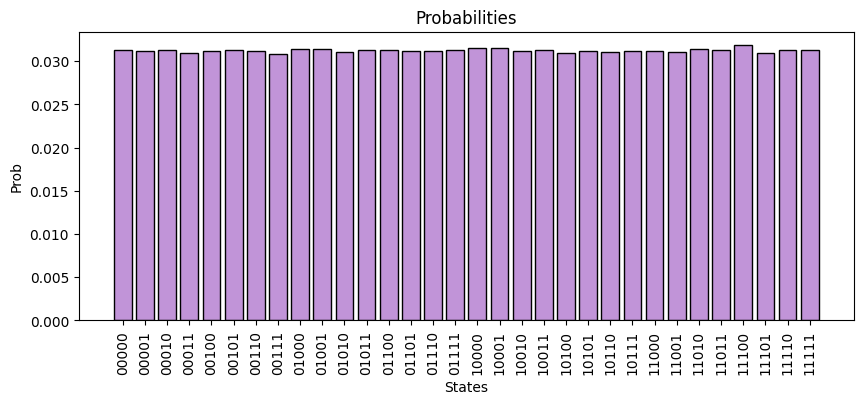

In [11]:
# use plot_grover_probabilities which requires the circuit and nshots
# here we are using the frequencies, and the result is no more exact
plotscripts.plot_grover_probabilities(c, nshots)

As we can see from the plot, the state is prepared into $|s\rangle$.

#### Oracle 

We need now to construct the oracle $U_f$. This can be done firstly building a function:

$$ f: \{0,1\}^n \to \{0,1\} $$

which returns $1$ in the only case in which the input variable $x$ is the one we are searching for, otherwise it returns $0$. Given this, the oracle $U_f$ acts on the $N$-qubits state $|x\rangle$ in the following way: $$ U_f |x\rangle = (-1)^{f(x)}|x\rangle, $$

flipping the amplitude of the state only if $|x\rangle$ is the guilty one:

$$ 
\begin{cases}
U_f\,|x\rangle = - |x\rangle \qquad \text{if} \quad |x\rangle \quad \text{guilty}, \\
U_f\,|x\rangle = + |x\rangle \qquad \text{if} \quad |x\rangle \quad \text{innocent}. \\
\end{cases}
$$

The easiest way to implement such an operator consists in building a multi-controlled gate which is "triggered" by the guilty state only. It means we need to define a gate which acts on the ancilla and, with its action, it provokes a phase kickback effect on the guilty state only. 

Since the multi-controlled gate is typically activated by the component $|1\rangle^{\otimes N}$ of the input register state, if the guilty state is the $|1\rangle^{\otimes N}$ itself, our job gets easier: in fact, the multi-controlled gate will already do the job we want to do. 

Otherwise, if the guilty state is something different from $|1\rangle^{\otimes N}$, we just need to manipulate the input register state so that the component which activates the gate is the guilty one instead. A simple way of doing this is apply a NOT gate to each qubit of the system which, in the bitstring, corresponds to a zero. 

In [12]:
def build_oracle(guilty_index, n):
    """Swap the guilty state."""
    # we pick up the guilty string
    bitstring = bitstrings[guilty_index]
    # n+1 qubits circuit
    circuit = Circuit(n+1)
    zeros = []
    for i, bit in enumerate(bitstring):
        if bit == "0":
            zeros.append(i)
    [circuit.add(gates.X(q)) for q in zeros]
    # triggered only if the control state is |111111>
    circuit.add(gates.X(q=n).controlled_by(*range(n)))
    [circuit.add(gates.X(q)) for q in zeros]
    return circuit

Let's have a look to the circuit.

In [13]:
# build the oracle circuit and draw it
c = build_oracle(guilty_index, n)

c.draw()

0: ─X─o─X─
1: ───o───
2: ─X─o─X─
3: ───o───
4: ───o───
5: ───X───


Execute the whole circuit involving the oracle.

In [14]:
# combine together initial_layer + oracle + final_layer and draw the circuit
c = build_initial_layer(n) + build_oracle(guilty_index, n) + build_final_layer(n)

c.draw()

0: ─H─X─o─X─M─
1: ─H───o───M─
2: ─H─X─o─X─M─
3: ─H───o───M─
4: ─H───o───M─
5: ─X─H─X─────


We can visualize the amplitudes of the input register using the function `scripts.plotscripts.plot_input_register_amplitudes`.

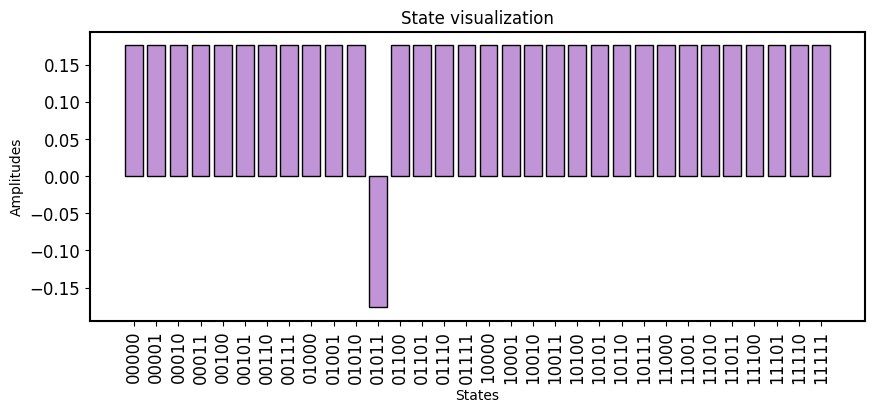

In [15]:
# plot the input register amplitudes using plot_input_register_amplitudes
plotscripts.plot_input_register_amplitudes(c().state())

Even though the amplitude of the guilty state is flipped, if we look to the probabilies associated to the states of the input register we still collect an equally superposed state.

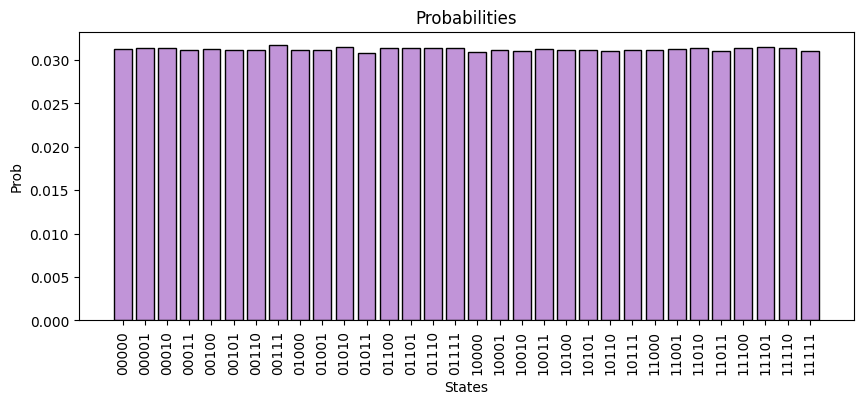

In [16]:
# plot the probabilities associated to this state using the plot_grover_probabilities function
# it requires the circuit and nshots as arguments
plotscripts.plot_grover_probabilities(c, nshots)

#### The diffusion operator

The next step in Grover is to implement the diffusion operator, whose effect is to amplify the guilty amplitude while decreasing the others.
Typically it is implemented using a multi-controlled Z gate acting on the ancilla e controlled by the input register. This multi-controlled Z has to be preceded and followed by a layer of Hadamards applied to the imput register. For now, we'll ask you to accept this statement as it is. In the notebook corresponding to the Lecture 5 we delve deeper in the details of this implementation.

One way to practically implement the CZ consists in applying an X gate to all the qubits of the input register, then apply a multi-controlled NOT gate on the ancilla and controlled by the whole input register. Finally, we have to re-apply the X gates to the input register. 

In [17]:
def build_diffusion_operator(n):
    # n+1 qubits circuit
    circuit = Circuit(n+1)
    circuit.add(gates.X(n))
    for q in range(n):
        circuit.add(gates.H(q=q))
        circuit.add(gates.X(q=q))
    circuit.add(gates.X(q=n).controlled_by(*range(n)))
    for q in range(n):
        circuit.add(gates.X(q=q))
        circuit.add(gates.H(q=q))
    return circuit

In [18]:
def build_grover(n, nsteps):
    """Build grover circuit with `n` qubits and repeating grover iteration `steps` times."""
    # n+1 qubits circuit
    c = Circuit(n+1)
    # initial layer
    c += build_initial_layer(n)
    # repeat nstepts time oracle + diffusion operator
    for _ in range(nsteps):
        # build_oracle requires guilty_index and n
        c += build_oracle(guilty_index, n)
        # build_diffusion operator requires just n
        c += build_diffusion_operator(n)
    # final layer
    c += build_final_layer(n)
    return c

In [19]:
# build grover circuit with nsteps=1
c = build_grover(n, 1)

# draw the circuit
c.draw()

0: ─H─X─o─X─H─X─o─X─H─M─
1: ─H───o─H─X───o─X─H─M─
2: ─H─X─o─X─H─X─o─X─H─M─
3: ─H───o─H─X───o─X─H─M─
4: ─H───o─H─X───o─X─H─M─
5: ─X─H─X─X─────X───────


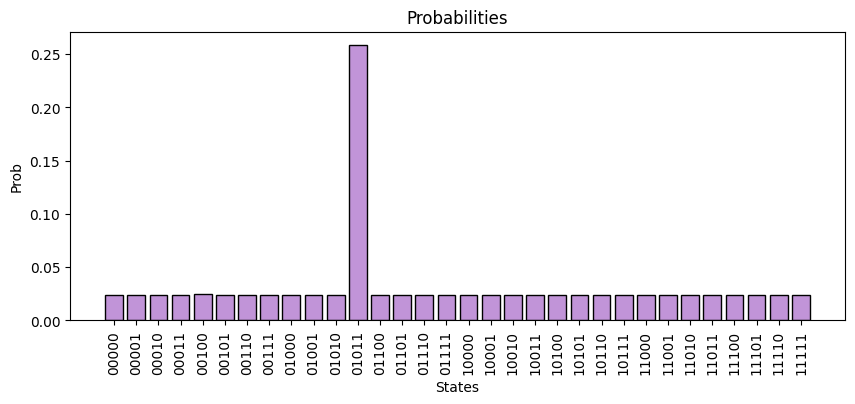

In [20]:
# plot_grover_probabilities, passing grover circuit and nshots
plotscripts.plot_grover_probabilities(c, nshots)

In [21]:
# build grover circuit with nsteps=2
c = build_grover(n, 2)

# draw the circuit
c.draw()

0: ─H─X─o─X─H─X─o─X─H─X─o─X─H─X─o─X─H─M─
1: ─H───o─H─X───o─X─H───o─H─X───o─X─H─M─
2: ─H─X─o─X─H─X─o─X─H─X─o─X─H─X─o─X─H─M─
3: ─H───o─H─X───o─X─H───o─H─X───o─X─H─M─
4: ─H───o─H─X───o─X─H───o─H─X───o─X─H─M─
5: ─X─H─X─X─────X───────X─X─────X───────


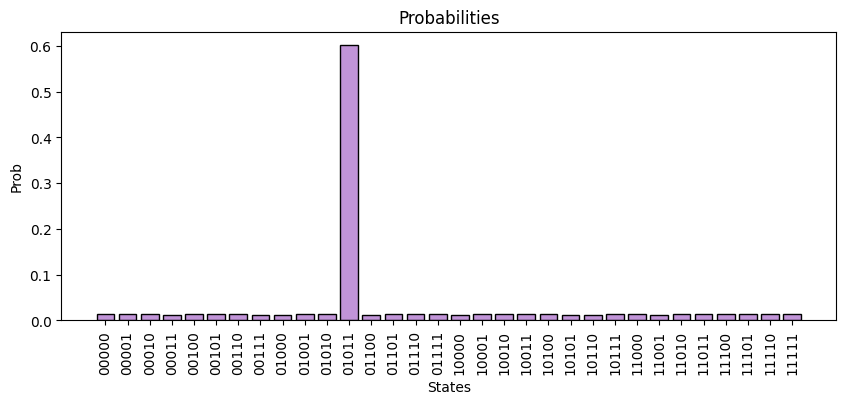

In [22]:
# plot_grover_probabilities, passing grover circuit and nshots
plotscripts.plot_grover_probabilities(c, nshots)

From the plot and the amplitudes of the final state it is clearer and clearer who is the guilty person!
In the following cell we check explicitly who is the guilty person.

In [23]:
# collect frequencies with the current circuit
frequencies = c(nshots=1000).frequencies()

# write the corresponding probabilities
probabilities = []
for bitstring in frequencies:
    probabilities.append(frequencies[bitstring] / 1000)

index = np.argmax(probabilities)
print(f"The guilty state is {bitstrings[index]} with probability {probabilities[index]}, corresponding to {names[index]}!")

The guilty state is 01011 with probability 0.577, corresponding to Megan Walker!


We expect the optimal number of Grover steps is $\sim\pi/4 \sqrt{M}$ from the theoretical results.
Let's check what happens with a growing number of steps.

In [24]:
opt = (np.pi / 4) * np.sqrt(2**n) 
print(f"Optimal number of steps: {opt}")

Optimal number of steps: 4.442882938158366


In [25]:
# allocate empty max probabilities list
prob_target = []

# set the number of experiments, e.g. for nsteps up to 10 and use build_grover(n, nsteps)
N = 15

# check for number of steps in np.arange(0, nsteps) using the utils.compute_max_probability(c, nshots) function
for i in range(N):
    c = build_grover(n, i)
    prob_target.append(utils.compute_max_probability(c, nshots))

Plot the sequence of registered probabilities.

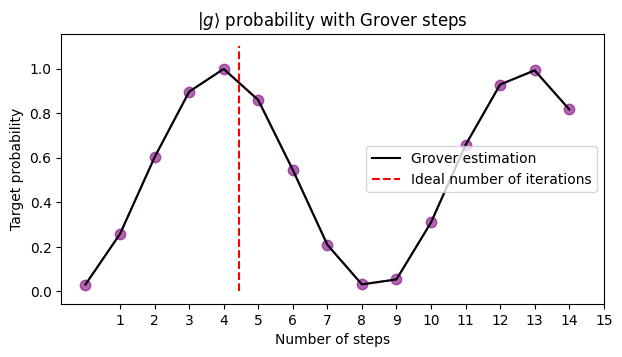

In [26]:
plt.figure(figsize=(7, 7*4/8))
plt.plot(np.arange(0, N), prob_target, ls="-", marker=".", markersize=15, alpha=0.6, color="purple")
plt.plot(np.arange(0, N), prob_target, ls="-", color="black", label="Grover estimation")
plt.vlines(opt, 0, 1.1, color="red", ls="--", label="Ideal number of iterations")
plt.xticks(np.arange(1, N+1))
plt.title(r"$|g\rangle$ probability with Grover steps")
plt.xlabel("Number of steps")
plt.ylabel("Target probability")
plt.legend()
plt.show()

In [27]:
# build grover circuit with optimal number of steps
c = build_grover(n, 4)

# draw the circuit
c.draw()

0: ─H─X─o─X─H─X─o─X─H─X─o─X─H─X─o─X─H─X─o─X─H─X─o─X─H─X─o─X─H─X─o─X─H─M─
1: ─H───o─H─X───o─X─H───o─H─X───o─X─H───o─H─X───o─X─H───o─H─X───o─X─H─M─
2: ─H─X─o─X─H─X─o─X─H─X─o─X─H─X─o─X─H─X─o─X─H─X─o─X─H─X─o─X─H─X─o─X─H─M─
3: ─H───o─H─X───o─X─H───o─H─X───o─X─H───o─H─X───o─X─H───o─H─X───o─X─H─M─
4: ─H───o─H─X───o─X─H───o─H─X───o─X─H───o─H─X───o─X─H───o─H─X───o─X─H─M─
5: ─X─H─X─X─────X───────X─X─────X───────X─X─────X───────X─X─────X───────


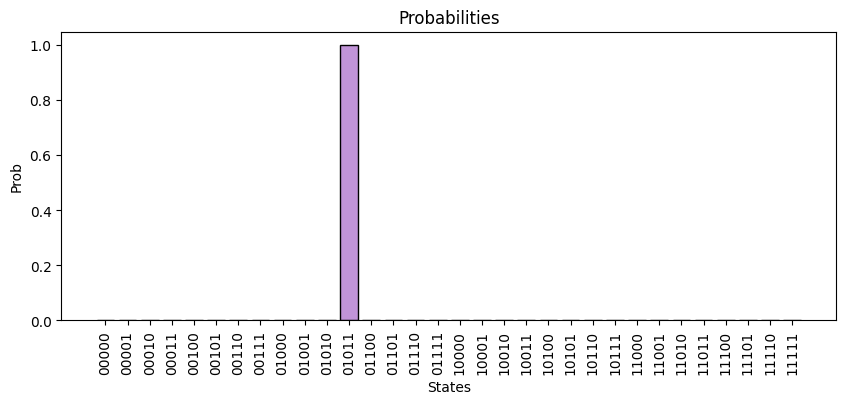

In [28]:
plotscripts.plot_grover_probabilities(c, nshots)